# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 35
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Optimizer

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [6]:
class FocalLoss_1(nn.Module):

    def __init__(self, weight=None, reduction='mean', gamma=0.5, eps=1e-7):
        super(FocalLoss_1, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight, reduction=reduction)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [7]:
class FocalLoss_2(nn.Module):

    def __init__(self, weight=None, reduction='mean', gamma=2, eps=1e-7):
        super(FocalLoss_2, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight, reduction=reduction)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [8]:
# Define the loss function
# criterion =  nn.CrossEntropyLoss()

In [9]:
# # def train_batch(model, image, target):
#     output = model(image)
#     loss = criterion(output, target)
#     return output, loss

In [10]:

# def test_batch(model, image, target):
#     output = model(image)
#     loss = criterion(output, target)
#     return output, loss

### Model Training

In [11]:
import matplotlib.pyplot as plt

def run4():
    training_loss = torch.zeros(4, NUM_EPOCHS).numpy()
    training_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    testing_loss = torch.zeros(4, NUM_EPOCHS).numpy()
    testing_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    num=0
    for k in range(4):
        print("###################################################")
        model = ConvNet()
        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
        if num==0:
            criterion = nn.L1Loss()
        elif num==1:
            criterion =nn.CrossEntropyLoss()
        elif num==2:
            criterion=FocalLoss_1()
        elif num==3:
            criterion=FocalLoss_2()


        def train_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        def test_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        for epoch in range(NUM_EPOCHS):
            model.train()
            torch.cuda.empty_cache()

            ##########################
            ### Training
            ##########################

            running_cls_loss = 0.0
            running_cls_corrects = 0

            for batch_idx, (image, target) in enumerate(train_dataloader):

                image = image.to(device)
                target = target.to(device)

                # train model
                outputs, loss = train_batch(model, image, target)
                _, preds = torch.max(outputs, 1)


                loss_data = loss.data.item()
                if np.isnan(loss_data):
                    raise ValueError('loss is nan while training')
                running_cls_loss += loss.item()
                running_cls_corrects += torch.sum(preds == target.data)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss = running_cls_loss / len(train_set)
            epoch_acc = running_cls_corrects.double() / len(train_set)

            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            training_loss[num,epoch]=epoch_loss
            training_acc[num,epoch]=epoch_acc.cpu().detach().numpy()

            # change learning rate
            scheduler.step()


            ##########################
            ### Testing
            ##########################
            # # eval model during training or in the last epoch
            if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
                print('Begin test......')
                model.eval()

                val_loss = 0.0
                val_corrects = 0

                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target)
                    _, preds = torch.max(outputs, 1)

                    val_loss += loss.item()
                    val_corrects += torch.sum(preds == target.data)

                val_loss = val_loss / len(test_set)
                val_acc = val_corrects.double() / len(test_set)
                print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
                testing_loss[num,epoch]=val_loss
                testing_acc[num,epoch]=val_acc.cpu().detach().numpy()

                # save the model in last epoch
                if (epoch +1) == NUM_EPOCHS:

                    state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                    }

                    # check the dir
                    if not os.path.exists(SAVE_DIR):
                        os.makedirs(SAVE_DIR)

                    # save the state
                    torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
        num=num+1
    return training_acc,testing_acc,training_loss,testing_loss

In [12]:
t1_tr_ac,t1_ts_ac,t1_tr_lo,t1_ts_lo=run4()

###################################################
Epoch: 1/35 Train Loss: 0.0013 Acc: 0.1925
Begin test......
Test Loss: 0.0012 Acc: 0.2554
Epoch: 2/35 Train Loss: 0.0012 Acc: 0.2470
Begin test......
Test Loss: 0.0012 Acc: 0.2658
Epoch: 3/35 Train Loss: 0.0012 Acc: 0.2528
Begin test......
Test Loss: 0.0011 Acc: 0.2754
Epoch: 4/35 Train Loss: 0.0012 Acc: 0.2639
Begin test......
Test Loss: 0.0011 Acc: 0.2867
Epoch: 5/35 Train Loss: 0.0011 Acc: 0.2698
Begin test......
Test Loss: 0.0011 Acc: 0.2868
Epoch: 6/35 Train Loss: 0.0011 Acc: 0.2827
Begin test......
Test Loss: 0.0011 Acc: 0.2996
Epoch: 7/35 Train Loss: 0.0011 Acc: 0.2917
Begin test......
Test Loss: 0.0011 Acc: 0.3164
Epoch: 8/35 Train Loss: 0.0011 Acc: 0.3012
Begin test......
Test Loss: 0.0011 Acc: 0.3263
Epoch: 9/35 Train Loss: 0.0011 Acc: 0.3073
Begin test......
Test Loss: 0.0011 Acc: 0.3353
Epoch: 10/35 Train Loss: 0.0011 Acc: 0.3182
Begin test......
Test Loss: 0.0010 Acc: 0.3462
Epoch: 11/35 Train Loss: 0.0011 Acc: 0.3291
Beg

Text(0, 0.5, 'acc')

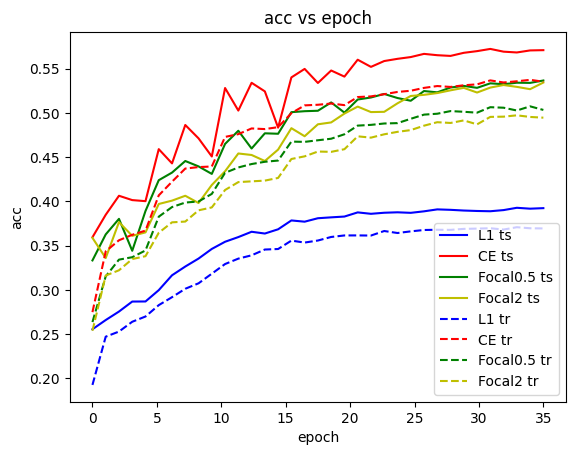

In [13]:
x = torch.linspace(0, 35,NUM_EPOCHS)


# 创建一个新的图形
plt.figure()
plt.title('acc vs epoch')
plt.plot(x, t1_ts_ac[0], linestyle='-', color='b',label="L1 ts")
plt.plot(x, t1_ts_ac[1], linestyle='-', color='r',label="CE ts")
plt.plot(x, t1_ts_ac[2], linestyle='-', color='g',label="Focal0.5 ts")
plt.plot(x, t1_ts_ac[3], linestyle='-', color='y',label="Focal2 ts")

plt.plot(x, t1_tr_ac[0], linestyle='--', color='b',label="L1 tr")
plt.plot(x, t1_tr_ac[1], linestyle='--', color='r',label="CE tr")
plt.plot(x, t1_tr_ac[2], linestyle='--', color='g',label="Focal0.5 tr")
plt.plot(x, t1_tr_ac[3], linestyle='--', color='y',label="Focal2 tr")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

Text(0, 0.5, 'loss')

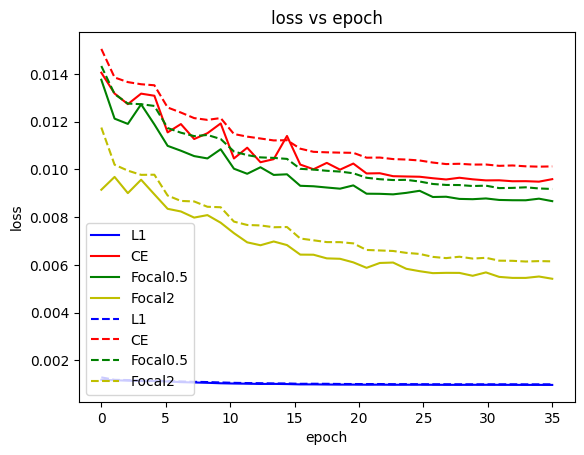

In [14]:
x = torch.linspace(0, 35,NUM_EPOCHS)


# 创建一个新的图形
plt.figure()
plt.title('loss vs epoch')
plt.plot(x, t1_ts_lo[0], linestyle='-', color='b',label="L1")
plt.plot(x, t1_ts_lo[1], linestyle='-', color='r',label="CE")
plt.plot(x, t1_ts_lo[2], linestyle='-', color='g',label="Focal0.5")
plt.plot(x, t1_ts_lo[3], linestyle='-', color='y',label="Focal2")

plt.plot(x, t1_tr_lo[0], linestyle='--', color='b',label="L1")
plt.plot(x, t1_tr_lo[1], linestyle='--', color='r',label="CE")
plt.plot(x, t1_tr_lo[2], linestyle='--', color='g',label="Focal0.5")
plt.plot(x, t1_tr_lo[3], linestyle='--', color='y',label="Focal2")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [23]:
import matplotlib.pyplot as plt

def run4_ad():
    training_loss = []
    training_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    testing_loss = []
    testing_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    num=0
    for k in range(4):
        print("###################################################")
        model = ConvNet()
        model.to(device)
        model_parameters = model.parameters()
        var1 = next(model_parameters)
        var2 = next(model_parameters)
        optimizer = optim.Adam([var1, var2], lr=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
        if num==0:
            criterion = nn.L1Loss()
        elif num==1:
            criterion =nn.CrossEntropyLoss()
        elif num==2:
            criterion=FocalLoss_1()
        elif num==3:
            criterion=FocalLoss_2()


        def train_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        def test_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        for epoch in range(NUM_EPOCHS):
            model.train()
            torch.cuda.empty_cache()

            ##########################
            ### Training
            ##########################

            running_cls_loss = 0.0
            running_cls_corrects = 0

            for batch_idx, (image, target) in enumerate(train_dataloader):

                image = image.to(device)
                target = target.to(device)

                # train model
                outputs, loss = train_batch(model, image, target)
                _, preds = torch.max(outputs, 1)


                loss_data = loss.data.item()
                if np.isnan(loss_data):
                    raise ValueError('loss is nan while training')
                running_cls_loss += loss.item()
                running_cls_corrects += torch.sum(preds == target.data)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss = running_cls_loss / len(train_set)
            epoch_acc = running_cls_corrects.double() / len(train_set)

            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            training_loss.append(epoch_loss)
            training_acc[num,epoch]=epoch_acc.cpu().detach().numpy()

            # change learning rate
            scheduler.step()


            ##########################
            ### Testing
            ##########################
            # # eval model during training or in the last epoch
            if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
                print('Begin test......')
                model.eval()

                val_loss = 0.0
                val_corrects = 0

                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target)
                    _, preds = torch.max(outputs, 1)

                    val_loss += loss.item()
                    val_corrects += torch.sum(preds == target.data)

                val_loss = val_loss / len(test_set)
                val_acc = val_corrects.double() / len(test_set)
                print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
                testing_loss.append(val_loss)
                testing_acc[num,epoch]=val_acc.cpu().detach().numpy()

                # save the model in last epoch
                if (epoch +1) == NUM_EPOCHS:

                    state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                    }

                    # check the dir
                    if not os.path.exists(SAVE_DIR):
                        os.makedirs(SAVE_DIR)

                    # save the state
                    torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
        num=num+1
    return training_acc,testing_acc

In [24]:
t2_tr_ac,t2_ts_ac=run4_ad()

###################################################
Epoch: 1/30 Train Loss: 0.0014 Acc: 0.1023
Begin test......
Test Loss: 0.0014 Acc: 0.1114
Epoch: 2/30 Train Loss: 0.0014 Acc: 0.1133
Begin test......
Test Loss: 0.0014 Acc: 0.1154
Epoch: 3/30 Train Loss: 0.0014 Acc: 0.1171
Begin test......
Test Loss: 0.0014 Acc: 0.1175
Epoch: 4/30 Train Loss: 0.0014 Acc: 0.1191
Begin test......
Test Loss: 0.0014 Acc: 0.1192
Epoch: 5/30 Train Loss: 0.0014 Acc: 0.1210
Begin test......
Test Loss: 0.0014 Acc: 0.1193
Epoch: 6/30 Train Loss: 0.0014 Acc: 0.1222
Begin test......
Test Loss: 0.0014 Acc: 0.1201
Epoch: 7/30 Train Loss: 0.0014 Acc: 0.1224
Begin test......
Test Loss: 0.0014 Acc: 0.1224
Epoch: 8/30 Train Loss: 0.0014 Acc: 0.1235
Begin test......
Test Loss: 0.0014 Acc: 0.1246
Epoch: 9/30 Train Loss: 0.0014 Acc: 0.1241
Begin test......
Test Loss: 0.0014 Acc: 0.1258
Epoch: 10/30 Train Loss: 0.0014 Acc: 0.1266
Begin test......
Test Loss: 0.0014 Acc: 0.1271
Epoch: 11/30 Train Loss: 0.0014 Acc: 0.1266
Beg

In [ ]:
import matplotlib.pyplot as plt

def run4_ad():
    training_loss = []
    training_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    testing_loss = []
    testing_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    num=0
    for k in range(4):
        print("###################################################")
        model = ConvNet()
        model.to(device)
        model_parameters = model.parameters()
        var1 = next(model_parameters)
        var2 = next(model_parameters)
        optimizer = optim.Adam([var1, var2], lr=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
        if num==0:
            criterion = nn.L1Loss()
        elif num==1:
            criterion =nn.CrossEntropyLoss()
        elif num==2:
            criterion=FocalLoss_1()
        elif num==3:
            criterion=FocalLoss_2()


        def train_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        def test_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        for epoch in range(NUM_EPOCHS):
            model.train()
            torch.cuda.empty_cache()

            ##########################
            ### Training
            ##########################

            running_cls_loss = 0.0
            running_cls_corrects = 0

            for batch_idx, (image, target) in enumerate(train_dataloader):

                image = image.to(device)
                target = target.to(device)

                # train model
                outputs, loss = train_batch(model, image, target)
                _, preds = torch.max(outputs, 1)


                loss_data = loss.data.item()
                if np.isnan(loss_data):
                    raise ValueError('loss is nan while training')
                running_cls_loss += loss.item()
                running_cls_corrects += torch.sum(preds == target.data)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss = running_cls_loss / len(train_set)
            epoch_acc = running_cls_corrects.double() / len(train_set)

            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            training_loss.append(epoch_loss)
            training_acc[num,epoch]=epoch_acc.cpu().detach().numpy()

            # change learning rate
            scheduler.step()


            ##########################
            ### Testing
            ##########################
            # # eval model during training or in the last epoch
            if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
                print('Begin test......')
                model.eval()

                val_loss = 0.0
                val_corrects = 0

                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target)
                    _, preds = torch.max(outputs, 1)

                    val_loss += loss.item()
                    val_corrects += torch.sum(preds == target.data)

                val_loss = val_loss / len(test_set)
                val_acc = val_corrects.double() / len(test_set)
                print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
                testing_loss.append(val_loss)
                testing_acc[num,epoch]=val_acc.cpu().detach().numpy()

                # save the model in last epoch
                if (epoch +1) == NUM_EPOCHS:

                    state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                    }

                    # check the dir
                    if not os.path.exists(SAVE_DIR):
                        os.makedirs(SAVE_DIR)

                    # save the state
                    torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
        num=num+1
    return training_acc,testing_acc

In [26]:
import matplotlib.pyplot as plt

def run4_NAG():
    training_loss = []
    training_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    testing_loss = []
    testing_acc =torch.zeros(4, NUM_EPOCHS).numpy()
    num=0
    for k in range(4):
        print("###################################################")
        model = ConvNet()
        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM,nesterov=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
        if num==0:
            criterion = nn.L1Loss()
        elif num==1:
            criterion =nn.CrossEntropyLoss()
        elif num==2:
            criterion=FocalLoss_1()
        elif num==3:
            criterion=FocalLoss_2()


        def train_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        def test_batch(model, image, target):
            output = model(image)
            if num!=0:
                loss = criterion(output, target)
            else:
                loss = criterion(F.softmax(output, dim=1),F.one_hot(target,num_classes=10))
            return output, loss

        for epoch in range(NUM_EPOCHS):
            model.train()
            torch.cuda.empty_cache()

            ##########################
            ### Training
            ##########################

            running_cls_loss = 0.0
            running_cls_corrects = 0

            for batch_idx, (image, target) in enumerate(train_dataloader):

                image = image.to(device)
                target = target.to(device)

                # train model
                outputs, loss = train_batch(model, image, target)
                _, preds = torch.max(outputs, 1)


                loss_data = loss.data.item()
                if np.isnan(loss_data):
                    raise ValueError('loss is nan while training')
                running_cls_loss += loss.item()
                running_cls_corrects += torch.sum(preds == target.data)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss = running_cls_loss / len(train_set)
            epoch_acc = running_cls_corrects.double() / len(train_set)

            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            training_loss.append(epoch_loss)
            training_acc[num,epoch]=epoch_acc.cpu().detach().numpy()

            # change learning rate
            scheduler.step()


            ##########################
            ### Testing
            ##########################
            # # eval model during training or in the last epoch
            if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
                print('Begin test......')
                model.eval()

                val_loss = 0.0
                val_corrects = 0

                for batch_idx, (image, target) in enumerate(test_dataloader):

                    image = image.to(device)
                    target = target.to(device)

                    # test model
                    outputs, loss = test_batch(model, image, target)
                    _, preds = torch.max(outputs, 1)

                    val_loss += loss.item()
                    val_corrects += torch.sum(preds == target.data)

                val_loss = val_loss / len(test_set)
                val_acc = val_corrects.double() / len(test_set)
                print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
                testing_loss.append(val_loss)
                testing_acc[num,epoch]=val_acc.cpu().detach().numpy()

                # save the model in last epoch
                if (epoch +1) == NUM_EPOCHS:

                    state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch+1),
                    }

                    # check the dir
                    if not os.path.exists(SAVE_DIR):
                        os.makedirs(SAVE_DIR)

                    # save the state
                    torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
        num=num+1
    return training_acc,testing_acc

In [27]:
t3_tr_ac,t3_ts_ac=run4_NAG()

###################################################
Epoch: 1/30 Train Loss: 0.0013 Acc: 0.1876
Begin test......
Test Loss: 0.0011 Acc: 0.2894
Epoch: 2/30 Train Loss: 0.0012 Acc: 0.2589
Begin test......
Test Loss: 0.0011 Acc: 0.2864
Epoch: 3/30 Train Loss: 0.0012 Acc: 0.2654
Begin test......
Test Loss: 0.0011 Acc: 0.2892
Epoch: 4/30 Train Loss: 0.0011 Acc: 0.2765
Begin test......
Test Loss: 0.0011 Acc: 0.2966
Epoch: 5/30 Train Loss: 0.0011 Acc: 0.2851
Begin test......
Test Loss: 0.0011 Acc: 0.2976
Epoch: 6/30 Train Loss: 0.0011 Acc: 0.2925
Begin test......
Test Loss: 0.0011 Acc: 0.3146
Epoch: 7/30 Train Loss: 0.0011 Acc: 0.2996
Begin test......
Test Loss: 0.0011 Acc: 0.3165
Epoch: 8/30 Train Loss: 0.0011 Acc: 0.3033
Begin test......
Test Loss: 0.0011 Acc: 0.3291
Epoch: 9/30 Train Loss: 0.0011 Acc: 0.3055
Begin test......
Test Loss: 0.0011 Acc: 0.3293
Epoch: 10/30 Train Loss: 0.0011 Acc: 0.3110
Begin test......
Test Loss: 0.0011 Acc: 0.3341
Epoch: 11/30 Train Loss: 0.0011 Acc: 0.3164
Beg

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [ ]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [ ]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

probabilities = 
predict_label = 

In [ ]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')